In [1]:
using Pkg

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra, KrylovKit
using StatsBase, Distances, Distributions
using CairoMakie
using DelimitedFiles
using Random
using Graphs, GraphMakie, NetworkLayout, SimpleWeightedGraphs

  Activating project at `~/Projects/Working/HIFMB/MiCRM_stability`


# Introduction

In this notebook I will look at the various factors determining stabiltiy in the generalised microbial model

In [2]:
function get_param_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    fs = fieldnames(MiCRM_stability.structural_params)

    ue = mean.(getfield.(Ref(p.e), fe))
    us = mean.(getfield.(Ref(p.s), fs))

    vcat(ue...,us...) 
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

Revise.revise()

In [3]:
#network structure functions
function get_A(com)
    N,M = com.N, com.M
    A = zeros(N+M, N+M)
    
    for i = 1:N
        for j = 1:M
            A[N + j, i] = com.U[i,j]
            A[i, N + j] = com.L[i,j]
        end
    end
    
    return(A)
end

function get_A_undir(com::MiCRM_stability.Community)
     N,M = com.N, com.M
    A = zeros(N+M, N+M)
    
    for i = 1:N
        for j = 1:M
            A[N + j, i] = com.U[i,j] + com.L[i,j]
            A[i, N + j] = com.L[i,j] + com.U[i,j]
        end
    end
    
    return(A)

end
    
function check_connected(com)
    A = get_A(com)
    g = SimpleWeightedDiGraph(A)
    return(is_connected(g))

    # return(sum(abs.(eigen(B).values) .< 1e-10) == 1 & all(sum(com.U,dims=2) .> 0))
end

check_connected (generic function with 1 method)

In [4]:
function rand_com(N,M,C, ci = rand(N), ca = rand(M))
    # ci = rand(N)
    ci = ci[sortperm(sum.(ci))]
    
    # ca = rand(M)
    ca = ca[sortperm(sum.(ca))]
    
    d = ci .- ca'
    # d = zeros(N,M)
    # for i = 1:N
    #     for j = 1:M
    #         d[i,j] = sign(sum(ci[i] .- ca[j])) * sqrt(sum((ci[i] .- ca[j]).^2))
    #     end
    # end
    
    fu(x, dist) = dist > x >= 0 ? rand() : 0.0
    fl(x, dist) = -dist < x < 0 ? rand() : 0.0
    
    U = zeros(N,M)
    L = zeros(N,M)

    # V = 0.01
    # a = (((1-C) / V) - (1/C)) * C^2
    # b = a * (1/C - 1)

    b = (1/C - 1)
    dβ = Beta(1, b)

    for i = 1:N
        ind = findmin(abs.(d[i,:]))[2]
        x = d[i,:] .- d[i,ind]
        U[i,:] .= fu.(x, rand(dβ))
        L[i,:] .= fl.(x, rand(dβ))
    end

    #end products    
    U[:,end] .= 0.0
    L[:,1] .= 0.0

    
    
    return(MiCRM_stability.Community(N,M,U,L))
end

function shuffle!(com::MiCRM_stability.Community)
    U,L = com.U, com.L
    N,M = com.N, com.M

    #U
    if rand() < 0.5
        ind = findall(com.U .!= 0)
        #sample links
        f = rand(ind)
        #dont assign upatke to last node
        t = rand(CartesianIndices((1:N, 1:(M-1))))

        tmp = U[f]
        U[f] = U[t]
        U[t] = tmp
    else
        ind = findall(com.L .!= 0)
        #sample links
        f = rand(ind)
        #dont assign upatke to last node
        t = rand(CartesianIndices((1:N, 2:M)))

        tmp = L[f]
        L[f] = L[t]
        L[t] = tmp
    end
        
   
end

shuffle! (generic function with 1 method)

In [5]:
#get trophic levels
function get_TL(A)
    v = sum(A, dims = 2)[:]
    v[v .== 0] .= 1
    Λ = diagm(v) - A
    
    if rank(Λ) >= length(A[1,:])
        s = inv(Λ) * v
        return s
    else
        return 0
    end
end

function get_TC(A)
    s = get_TL(A)

    if s != 0  
        S = length(s)
        x = [s[i] - s[j] for i = 1:S, j = 1:S]
        return std(x[x .!= 0])
    else
        return 0
    end
end

get_TC (generic function with 1 method)

In [6]:
Random.seed!(1)

#test 
N = 100
M = 100
C = 0.2

a = rand_com(N,M, C)
while !check_connected(a)
    a = rand_com(N,M, C)
end

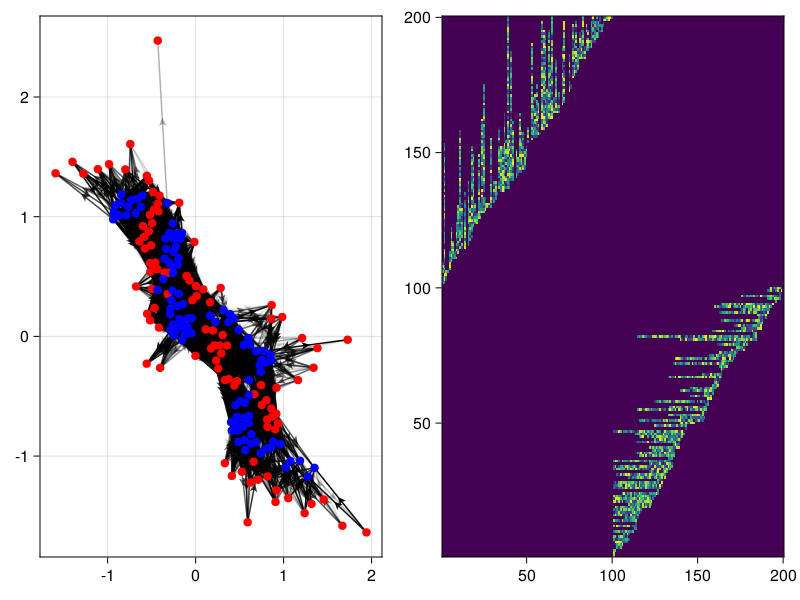

In [7]:
A = get_A(a)
tl = get_TL(A)

c = vcat(fill(:red,N),fill(:blue,M))
# c[sum(A, dims = 1)[:] .== 0] .= :green
# c[sum(A, dims = 2)[:] .== 0] .= :orange
# c = [(v, 0.9 + 0.1*(tl[i] / maximum(tl)) ) for (i,v) = enumerate(c)]

    
g = SimpleWeightedDiGraph(A)
# c = get_TL(A)

ec = [(:black, i.weight) for i = collect(edges(g))]
layout = Spring() #mylayout(g, N, M, A)

f = Figure()
graphplot!(Axis(f[1,1]), g, layout = layout, node_color = c, edge_color = ec)
heatmap!(Axis(f[1,2]), A)
f

In [8]:
get_TC(A)

3.679896227029008

In [9]:
#plotting layout
function mylayout(g, N, M, A)
    #get avg for consumers
    con_indx = [findall(A[(N+1):end,i] .!= 0) for i = 1:N]
    con_wt = [filter(x -> x != 0, A[(N+1):end, i]) for i = 1:N]
    con_wt = [con_wt[i] ./ sum(con_wt[i]) for i = 1:N]
    con_mean = [sum(con_indx[i] .* con_wt[i]) for i = 1:N]
    
    sN = sum(A, dims = 2)[1:N]

    
    xs = vcat(con_mean, 1:M)
    ys = vcat(ones(N), fill(0.0, M))
   

    return Point.(zip(xs, ys))
end


function plot_com!(com, ax; ns = 10, as = 0.1)
    A = get_A(com)
    c = vcat(fill(:red,com.N),fill(:blue,com.M))
    c[com.N+1] = :green
    c[end] = :green

    ns = ns .* ones(com.N + com.M)
    as = as .* sum(A .> 0)
    
    g = SimpleWeightedDiGraph(A)
    ec = [(:black, max(i.weight,0.1)) for i = collect(edges(g))]
    layout = Spring()#mylayout(g, N, M, A)
    graphplot!(ax, g, layout = layout, node_color = c, node_size = ns, edge_color = ec, arrow_size = as)
end

plot_com! (generic function with 1 method)

In [10]:
Random.seed!(1)
N,M = 20,30
C = 0.15

com = rand_com(N,M,C)
while !check_connected(com)
    com = rand_com(N,M, C)
end

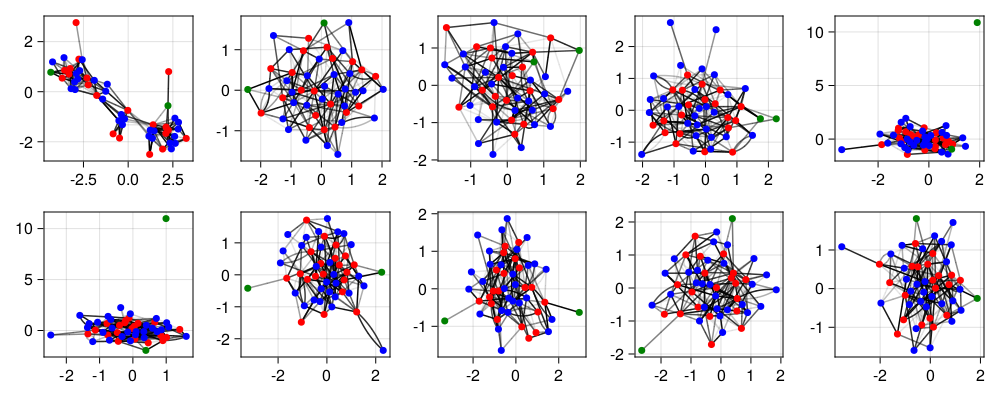

In [11]:
f = Figure(resolution = (1000, 400))
ax = hcat([[Axis(f[j,i]) for i = 1:5] for j = 1:2]...)

for i = 1:10
    plot_com!(com, ax[i], as = 0.01)
    [shuffle!(com) for i = 1:(100)]
end
f

In [12]:
# Random.seed!(1)
# N,M = 50,100
# C = 0.1
# σ = [1.0, 0.0, 0.0, 0.0, 0.0]
# # com = MiCRM_stability.correlated_rand_model(N,M,σ, C, C)
# com = rand_com(N,M, 0.2)
# A = check_connected(com)
# println(A)

# Ns = 301
# ut = zeros(Ns)
# d = zeros(Ns)

# for i = 1:Ns
#     shuffle!(com)
#     A = get_A(com)
    
#     try
#         ind = TL(A) |> sortperm
#         A = get_A(com)
#         ut[i] = sum(LowerTriangular(A[ind,ind])) / sum(A)
#     catch
#         ut[i] = 0
#     end

#     g = SimpleWeightedDiGraph(A)
#     src = filter(x -> x > N, findall(indegree(g) .== 0))
#     snk = filter(x -> x > N, findall(outdegree(g) .== 0))
#     d[i] = Graphs.gdistances(g, src)[snk] |> mean
    
# end

# Dynamic Parameters

First we look at the effects of the dynamic/exponetial parameters in the model. Here I simulate 10000 systems with different parameter values which we can then correlate with the stability metrics

In [13]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = rand(Uniform(0.0, 1.0)) .+ zeros(N)
    gs = rand(Uniform(0,3)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(0,3)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(0, 1.0)) .+ zeros(N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M) 
    ωy = zeros(N,M)


    iy = rand(Uniform(0.0,1.0)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(0.5,1.5)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [14]:
N,M = 50,100
C = 0.2
Ncom = 5000
Nrep = 1

k = [0]

p_names = vcat(fieldnames(MiCRM_stability.structural_params)..., fieldnames(MiCRM_stability.exponential_params)...)

λ_mat = zeros(Ncom, Nrep)
r_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep, length(p_names))
# s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
c_mat = Array{MiCRM_stability.Community, 1}(undef, Ncom)

Threads.@threads for i = 1:Ncom
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end

    #generate inital community
    f = true
    c = 0
    while f
        #connectance
       
        c = rand_com(N,M,C)
        # c = MiCRM_stability.correlated_rand_model(N,M,[1.0,0.0,0.0,0.0,0.0],C,C)
        
        f = !check_connected(c)
    end

    #copy matrix
    c_mat[i] = deepcopy(c)

    #calculate trophic coherence
    TC = get_TC(get_A(c_mat[i]))

    # #save structural metrics
    # s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
    #          mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
    #         N,M, mean(c.U .!= 0), N/M, TC, 0, 0]
    
    #allocate jacobian
    J = zeros(c.N+c.M,c.N+c.M)    
    #loop over reps
    for j = 1:Nrep
        
        #generate parameters
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)

        #calculate stabiltiy
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigsolve(J, 1, (:LR))[1][1])

        #save parameters used
        p_mat[i,j,:] .= vcat(get_param_mean(p))
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

[4900]
876


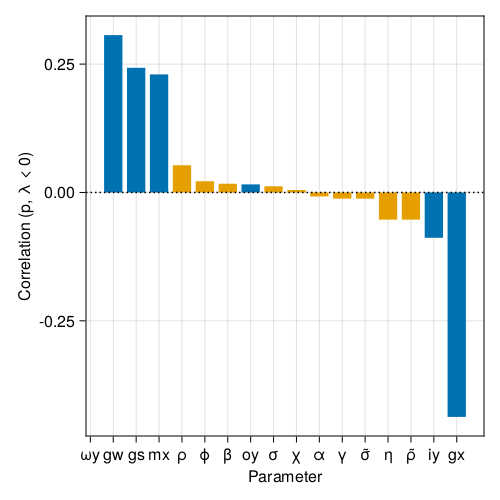

In [15]:
#plotting
#get param names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

f = Figure(resolution = (500,500))

#stability correlation
stab = (λ_mat .< -1e-5)[:,1]
cor_vec = [cor(stab, p_mat[:,1,p]) for p = 1:length(p_names)]
s_ind = sortperm(cor_vec, rev=true)
ax2 = Axis(f[1,1], xlabel = "Parameter", ylabel = "Correlation (p, λ < 0)",
    xticks = (1:length(p_names), string.(vcat([fe...,fs...]...))[s_ind]))

c = Makie.wong_colors()
c_vec = vcat(fill(c[1], length(fe)),fill(c[2], length(fs)),fill(c[3], 9))
lab = vcat(fill("Exponential", length(fe)),fill("Structural", length(fs)),fill("Other", 9))
barplot!(ax2, cor_vec[s_ind], color = c_vec[s_ind], label = lab)
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

f

In [16]:
save("../Results/Figures/stability_correlations.png", f)

CairoMakie.Screen{IMAGE}


Overal the Here we can see the effect of the various parameters. 

Positively affecting stability are the sensitvtiy of contributions f_{ia}^{(y)}, the sensitvity of uptake to substrate ammount $g_{i}^{(s)}$, the sesitvtiy of consumer mortality $m_i^{x}$ and the sensitvity of resource outflow $o_{a}^{y}$.

Negatively affecting stabiltiy is the sensitvity of leakage proportion to resource abundance $\lambda_i^{(y)}$, the sensitvity of uptake to waste and consumer abundance $g_{i}^{(w)}, g_{i}^{(x)}$ as well as the sensitvtiy of resource inflow $i_a^{(y)}$

These results make sense and suggest two mechanisms for stability. 

First is the self-inhibition through which consumers and resources are naturaly stable due to the self-dynamics. This is seen in the stabilising effects of the mortality and loss terms $m_i^{(x)}$ and $o_a^{(y)}$ the destabilising effects of the sensitity of uptake and resource inflow $g_{i}^{(x)}$ and $i_a^{(y)}$. These terms all appear in the diagonal elements of the Jacobian and thus promote stability by reducing their values (thus shifting all eigenvalues towards negative values). 

Second is the capacity of consumers to respond to resource perturbations, shown in the sensitivtiy of uptake to substrates and waste products $g_{i}^{(s)},g_{i}^{(w)}$ which stabilise and destabilise respectively. This suggests an additional mechanism of stabilisation which depends on the abiltiy of consumers to quickly respond to changes in resource concentration. Waste product inhibition prevents this here and is thus a destabiltiying force. This is further supported by the switching terms $f_{ia}^{(y)}$ and $h_{ia}^{(y)}$ which determine the sensitvtiy with which consumers switch their uptake profiles based on resource abundance.

## Switching Parameters

In [57]:
function get_exponential_parameters(N,M)
    σ = 0.05
    gx = ones(N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = -ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = 1.1ones(N) .+ zeros(N)
    
    fy = rand(Uniform(0,1)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(-1,0)) .+ rand(Uniform(-σ,σ),N,M)
    
    λy = rand(Uniform(-1,0.0)) .+ rand(Uniform(-σ,σ),N,M)
    ωy = rand(Uniform(0,1)) .+ rand(Uniform(-σ,σ),N,M)

    iy = zeros(M) #.+ rand(Uniform(-σ,σ), M)
    oy = ones(M)  #.+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [58]:
N,M = 50,100
C = 0.2
Ncom = 5000
Nrep = 1

J_stab = 0
c_stab = 0
c = 0

k = [0]

λ_mat = zeros(Ncom, Nrep)
r_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep,27)
s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
p = 0

Threads.@threads for i = 1:Ncom
    # N = 50 #rand(1:100)
    # M = 50 #rand(1:100)
    
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end
    J = zeros(N+M,N+M)
        
    f = true
    c = 0
    while f
        c = rand_com(N,M,C)
        f = !check_connected(c)
    end
        
    s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
             mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
            N,M,mean(c.U),N/M, 0]
    
    for j = 1:Nrep
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(N,M,sp,ep)
        
        s_vec[end] = mean(p.e.ωy ./ (p.e.λy .+ p.e.ωy))
        
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigsolve(J, 1, (:LR))[1][1])

        if λ_mat[i,j] < 0
            global J_stab = deepcopy(J)
            global c_stab = deepcopy(c)
        end

        H = Hermitian(J)
        r_mat[i,j] = eigvals(H)[end]
        
        p_mat[i,j,:] .= vcat(get_param_mean(p), s_vec)
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

[4900]
610


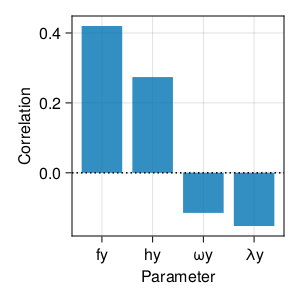

In [59]:
fe = fieldnames(MiCRM_stability.exponential_params)

#bootstrap CI
Nsamp = 1
stab = λ_mat[:] .< -1e-5
cor_samples = zeros(size(p_mat, 3), Nsamp)

for i = axes(p_mat, 3)
    for j = 1:Nsamp
        cor_samples[i,j] = corspearman(p_mat[:,1,i], stab)
    end
end

ind = 5:8

ρ_μ = mean(cor_samples, dims = 2)[ind]
ρ_lb = mapslices(x -> isnan(x[1]) ? NaN : quantile(x, 0.05), cor_samples, dims = 2)[ind] .- ρ_μ
ρ_ub = ρ_μ .- mapslices(x -> isnan(x[1]) ? NaN : quantile(x, 0.95), cor_samples, dims = 2)[ind]

s_ind = sortperm(ρ_μ, rev=true)

f = Figure(resolution = (300,300))

# ax1 = Axis(f[1,1], xlabel = "Leading Eigenvalue (J)")
# hist!(ax1, Real.(λ_mat)[:])
# vlines!(ax1, [0.0])

# ax1 = Axis(f[1,2], xlabel = "Leading Eigenvalue (H)")
# hist!(ax1, Real.(r_mat)[:])
# vlines!(ax1, [0.0])

ax2 = Axis(f[1,1], xlabel = "Parameter", ylabel = "Correlation",
    xticks = (1:4, hcat(string.(fe)[ind][s_ind]...)[:] ))

barplot!(ax2, ρ_μ[s_ind])
errorbars!(ax2, 1:4, ρ_μ[s_ind], ρ_lb[s_ind], ρ_ub[s_ind])
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

f

In [432]:
save("../Results/Figures/switching_correlations.png", f)

CairoMakie.Screen{IMAGE}


The resource switching seems to match the perturbation minimisation idea. It is stabilising to have switching towards abundant resources and destabilising to have uptake that is sensitive to waste products. 

Overall leakage is destabilising, leaking a higher proportion of resources into the environment leads to unstable communties. In particular the sensitvtiy of the leakage proportion 

# Structure

## Commiunity size and connectance

First we look at how the size and connectance of communities affects thier stabiltiy

In [254]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [264]:
#size and connectance
Nrep = 500
NC = 2
n = 20
m = 20

N_vec = Int.(floor.(range(2, n+1, length = n)))
M_vec = Int.(floor.(range(2, m+1, length = m)))

λ_mat = zeros(n,m,NC,Nrep)
N_mat = similar(λ_mat)
M_mat = similar(λ_mat)

k = [0]
Threads.@threads for i = 1:n
    for j = 1:m
        N = N_vec[i]
        M = M_vec[j]
        
        k[1] += 1
        print("\r", k[1])

        J = zeros(N_vec[i] + M_vec[j], N_vec[i] + M_vec[j])
        for c = 1:NC
             for k = 1:Nrep
                f = true
                com = 0
                while f 
                    com = rand_com(N_vec[i], M_vec[j], c / (NC+1))
                    f = !check_connected(com)
                end
                com_copy = deepcopy(com)
                f = true
                
                while f
                    [Main.shuffle!(com_copy) for i = 1:1000]
                    if check_connected(com)
                        com = deepcopy(com_copy)
                        f = false
                    else
                       com_copy = deepcopy(com)
                    end
                end
                sp = MiCRM_stability.get_structural_params(com.U,com.L, com.N, com.M)
                ep = get_exponential_parameters(com.N, com.M)
                p = MiCRM_stability.Parameters(com.N,com.M,sp,ep)      
                
                MiCRM_stability.jacobian!(p, J)
                λ_mat[i,j,c,k] = get_real(eigsolve(J, 1, (:LR))[1][1])
                N_mat[i,j,c,k] = N_vec[i]
                M_mat[i,j,c,k] = M_vec[j]
            end
        end
    end
end

400

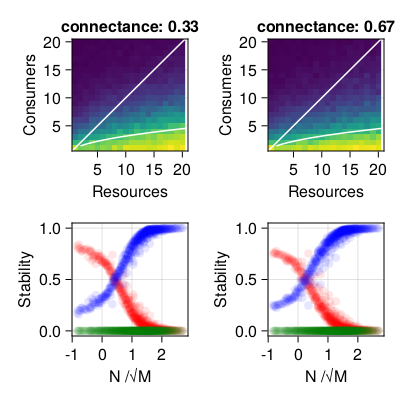

In [268]:
f = Figure(resolution = (400,400))
thresh = 1e-10

for (i,v) = enumerate(1:NC)
    ax = Axis(f[1,i], title = join(["connectance: ", round(i / (NC+1), digits = 2)]), xlabel = "Resources", ylabel = "Consumers")
    s_mat = mean(λ_mat .< -thresh, dims = 4)[:,:,v,1]
    z_mat = mean(abs.(λ_mat) .< thresh, dims = 4)[:,:,v,1]
    u_mat = mean((λ_mat) .> thresh, dims = 4)[:,:,v,1]

    heatmap!(ax, s_mat')
    # for j = 1:n
    #     for k = 1:m
    #         c = RGBf(s_mat[j,k],z_mat[j,k],u_mat[j,k])
    #         poly!(ax, Rect(k+1, j+1, 1.0,1.0), color = c)
    #     end
    # end

    ablines!(ax, [0], [1], color = "white")
    lines!(ax, M_vec, sqrt.(M_vec), color = "white")

    ax = Axis(f[2,i], xlabel = "N /√M", ylabel = "Stability")    
    a = N_vec ./ M_vec'
    b = (N_vec) ./ sqrt.(M_vec)'
    c = log.(b)

    scatter!(ax, c[:], s_mat[:], color = ("red", 0.1))
    scatter!(ax, c[:], u_mat[:], color = ("blue", 0.1))
    scatter!(ax, c[:], z_mat[:], color = ("green", 0.1))

end

f

In [150]:
# save("../Results/Figures/size_conn_stability.png")

#27 (generic function with 1 method)

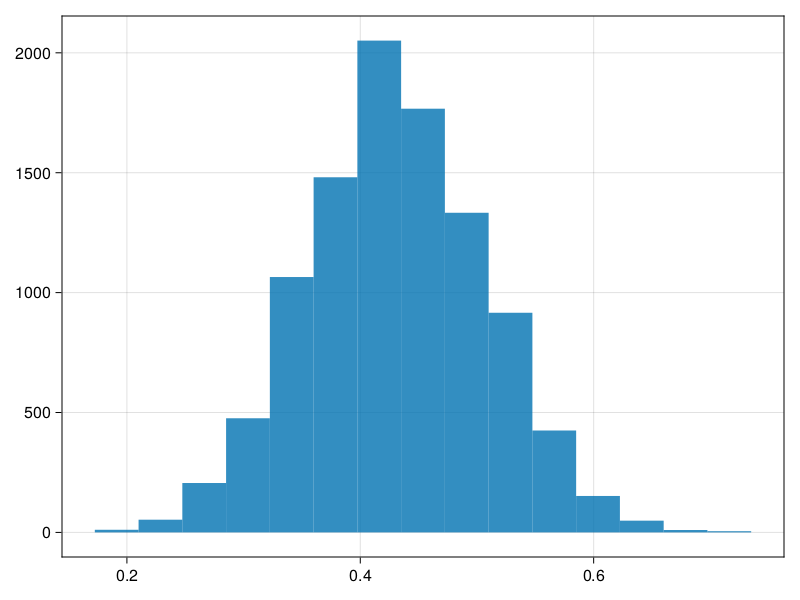

In [281]:
com = [rand_com(20, 20, 0.69).U .> 0 for i = 1:10000]

mean.(com) |> hist

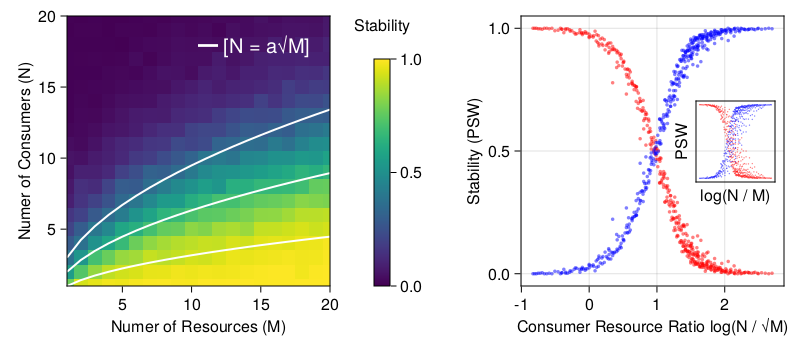

In [151]:
s_mat = mean(λ_mat .< -thresh, dims = 4)[:,:,3,1]
u_mat = mean((λ_mat) .> thresh, dims = 4)[:,:,3,1]

f = Figure(resolution = (800,350))

ax = Axis(f[1:2,1], xlabel = "Numer of Resources (M)", ylabel = "Numer of Consumers (N)")
heatmap!(ax, s_mat')
#contours
# cn = range(0.1, 0.99, length = 6)
# contour!(ax,M_vec,N_vec, s_mat', color = "white", levels = cn)
lines!(ax, 1:m, 1sqrt.(1:m), color = "white", label = "[N = a√M]", linewidth = 2)
lines!(ax, 1:m, 2sqrt.(1:m), color = "white", label = "[N = a√M]", linewidth = 2)
lines!(ax, 1:m, 3sqrt.(1:m), color = "white", label = "[N = a√M]", linewidth = 2)

axislegend(ax, framevisible = false, labelcolor = "white",labelsize = 20, merge = true)
Label(f[1,2], "Stability")
Colorbar(f[2,2])

xlims!(ax, 1,m)
ylims!(ax, 1,m)

ax = Axis(f[1:2,3], xlabel = "Consumer Resource Ratio log(N / √M)", ylabel = "Stability (PSW)")
x = log.(N_vec ./ sqrt.(M_vec)')[:]
scatter!(ax, x, s_mat[:], color = ("red", 0.5), markersize = 5)
scatter!(ax, x, u_mat[:], color = ("blue", 0.5), markersize = 5)

#inset plot
ax = Axis(f[1:2,3], xlabel = "log(N / M)", ylabel = "PSW", 
    height = Relative(0.3), width = Relative(0.3), 
    valign = 0.55, halign = 0.95)
x = log.(N_vec ./ (M_vec)')[:]
scatter!(ax, x, s_mat[:], color = ("red", 0.5), markersize = 2)
scatter!(ax, x, u_mat[:], color = ("blue", 0.5), markersize = 2)
hidedecorations!(ax, label = false)

f

There is a clear relationship between the N/M ratio and stability. the relationship seems to be more like $\frac{N}{\sqrt{M}}$. Increasing connectance seems to reduce stability (with the extra constraint of connected webs)

In [152]:
save("../Results/Figures/size_stability.png", f)

CairoMakie.Screen{IMAGE}


## Interaction strength

How does the overlap in consumer uptake and leakage fluxes affect stability? This corresponds to the level of competition and facilitation in the community respectively. 

In [61]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 1 .+ rand() .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

function get_psw(c, Nrep)
    λ = zeros(Complex, Nrep)
    sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M) 
    J = zeros(c.N + c.M, c.N + c.M)
    for k = 1:Nrep
        #get params and stabiltiy
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp, ep) 
        MiCRM_stability.jacobian!(p, J)
        λ[k] = eigsolve(J, 1, (:LR))[1][1]
    end

    return(mean(get_real.(λ) .< 0))
end

get_psw (generic function with 1 method)

In [107]:
N = 25
M = 100

J = zeros(N+M, N+M)

Nover = 100
Ncom = 10
Nrep = 100

overlap_vec = rand(Nover)
overlap = zeros(Nover, Ncom, 2)

psw_mat = zeros(Nover, Ncom)
c_mat = Array{MiCRM_stability.Community, 2}(undef, Nover, Ncom)

k = [0]
Threads.@threads for i = 1:Nover
    k[1] += 1
    print(k, "\r")
    for j = 1:Ncom    
        c = rand_com(N,M,0.2, overlap_vec[i] * rand(N), overlap_vec[i] * rand(M))
        
        while !check_connected(c)
            c = rand_com(N,M,0.2, overlap_vec[i] * rand(N), overlap_vec[i] * rand(M))
        end
        c_mat[i,j] = c
        
        psw_mat[i,j] = get_psw(c, Nrep)
    end
end

In [108]:
Threads.@threads for i = 1:Nover
    for j = 1:Ncom  
        c = c_mat[i,j]
        overlap[i,j,1] = mean(1 .- pairwise(jaccard, eachrow(c.U), eachrow(c.U)))
        overlap[i,j,2] = mean(1 .- pairwise(jaccard, eachrow(c.U), eachrow(c.L)))
    end
end

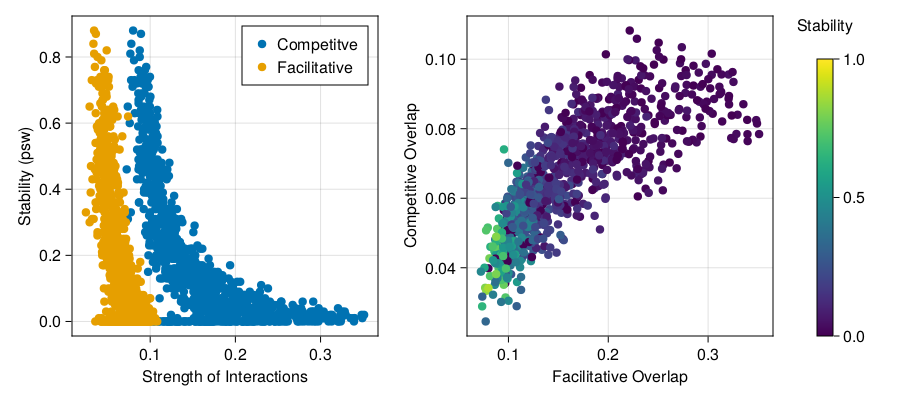

In [128]:
f = Figure(resolution = (900, 400))

ax = Axis(f[1:2,1], ylabel = "Stability (psw)", xlabel = "Strength of Interactions")
plot!(ax, (overlap[:,:,1][:]), psw_mat[:], color = Makie.wong_colors()[1], label = "Competitve")
plot!(ax, (overlap[:,:,2][:]), psw_mat[:], color = Makie.wong_colors()[2], label = "Facilitative")
axislegend(ax)

ax = Axis(f[1:2,2], xlabel = "Facilitative Overlap",  ylabel = "Competitive Overlap")
plot!(ax, (overlap[:,:,1][:]), (overlap[:,:,2][:]), color = psw_mat[:], colorrange = [0,1])
Label(f[1,3], "Stability")
Colorbar(f[2,3])


f

In [130]:
save("../Results/Figures/Interactions.png", f)

CairoMakie.Screen{IMAGE}


## Random vs niche model
How important is the structure created by the niche model?

In [141]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.95 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [142]:
N = 25
M = 100
C = 0.2
Ncom = 100
Nrep = 100
Nshuffle = 2

J = zeros(N+M,N+M)

λ_mat = zeros(Ncom, Nshuffle, Nrep)
c_mat = Array{MiCRM_stability.Community, 2}(undef, Ncom, Nshuffle)
c = 0
k = [0]

Threads.@threads for i = 1:Ncom
    k[1] += 1
    print("\r", k)
    
    #generate communites - assert it is connected
    begin
        f = true
        c = 0
        
        while f
            c = rand_com(N,M,C)
            f = !check_connected(c)
        end
        
        c.U .= c.U .* rand(N,M)
        c.L .= c.L .* rand(N,M)
    end

    for j = 1:Nshuffle
        # #get struct
        c_mat[i,j] = deepcopy(c)
        
        #shuffle
        c_vec = Vector{MiCRM_stability.Community}(undef, 1001)
        c_vec[1] = deepcopy(c)
        for s = 2:1000
            dis_con = true
            while dis_con
                shuffle!(c)
                if check_connected(c)
                        dis_con = false
                else
                    c = deepcopy(c_vec[s-1])
                end
            end
            c_vec[s] = deepcopy(c)
        end
    end
end

# print(mean(λ_mat .< 0, dims = 3)[:,:,1])

[100]

In [143]:
#calculate stabiltiy
function calc_stab(c, Nrep)
    λ = zeros(Complex, Nrep)
    sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M) 
    J = zeros(c.N + c.M, c.N + c.M)
    for k = 1:Nrep
        #get params and stabiltiy
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp, ep) 
        MiCRM_stability.jacobian!(p, J)
        λ[k] = eigsolve(J, 1, (:LR))[1][1]
    end

    return(λ)
end



calc_stab (generic function with 1 method)

In [144]:
#calculate stabiltiy
λ = zeros(Ncom, Nshuffle)
λ2 = zeros(Ncom, Nshuffle)

k = [0]
Threads.@threads for i = 1:Ncom
    k[1] += 1
    for j = 1:Nshuffle
        print(k, "\r")
        λ[i,j] = mean(get_real.(calc_stab(c_mat[i,j], Nrep)).< 0)
    end
end

In [145]:
TC_vec = get_TC.(get_A.(c_mat));

┌ Warning: Since there are a lot of edges (794 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/yyvus/src/recipes.jl:526


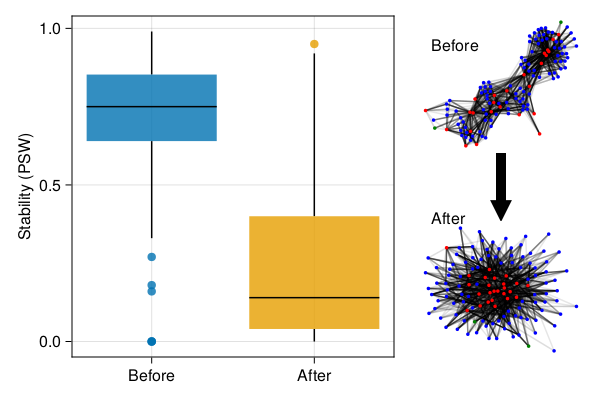

In [148]:
f = Figure(resolution = (600,400))
ax = Axis(f[1:3,1], xticks = (0:1, ["Before","After"]), ylabel = "Stability (PSW)")

# ylims!(ax, 0,1)

boxplot!(ax, zeros(Ncom), λ[:,1])
boxplot!(ax, ones(Ncom), λ[:,end])

#plot communities
ax = Axis(f[1,2], backgroundcolor=:white, spinewidth = 0)
plot_com!(c_mat[1,1], ax, ns = 5, as = 0.001)
hidedecorations!(ax)

ax = Axis(f[3,2],backgroundcolor=:white,spinewidth = 0)
plot_com!(c_mat[1,end], ax, ns = 5, as = 0.001)
hidedecorations!(ax)

colsize!(f.layout, 1, Relative(0.66))

Label(f[1,2], "Before", width = Relative(0.2), height = Relative(0.2), valign = 0.9, halign = 0.1)
Label(f[3,2], "After", width = Relative(0.2), height = Relative(0.2), valign = 1.2, halign = 0.1)

ax = Axis(f[2,2], spinewidth = 0)
arrows!(ax, [0.5], [1], [0.0], [-0.8], arrowsize = 30, linewidth = 10)
hidedecorations!(ax)
ylims!(ax, 0, 1)
rowsize!(f.layout, 2, Relative(0.2))
rowgap!(f.layout, 1)

# boxplot!(ax, zeros(Ncom), log.(TC_vec[:,1]))
# boxplot!(ax, ones(Ncom), log.(TC_vec[:,end]))

f

In [149]:
save("../Results/Figures/Shuffle_webs.png", f)

CairoMakie.Screen{IMAGE}


In [248]:
### General structural metrics
ad_mats = get_A.(c_mat[:,1])
g = SimpleWeightedDiGraph.(ad_mats)

#get avg path
d_mat = zeros(Ncom)
for l = eachindex(g)
    c = c_mat[l,1]
    src = findall( sum(c.L, dims = 1)[:] .== 0 )    
    walks = [non_backtracking_randomwalk(g[l], s, 1000) for s = src]
    d_mat[l] = median(vcat(walks...))
end

In [253]:
cor(λ[:,1], d_mat)

-0.01217322780588602

In [243]:
g = SimpleWeightedDiGraph(get_A(c))

src = findall( sum(c.L, dims = 1)[:] .== 0 )
snk = findall( sum(c.U, dims = 1)[:] .== 0 )

col = fill(:grey, c.N + c.M)
col[c.N .+ src] .= :blue
col[c.N .+ snk] .= :red

dist = [a_star(g, c.N + src[i], c.N + snk[j]) |> length for i = eachindex(src), j = eachindex(snk)]

mean(dist)
# graphplot(g, node_color = col)

7.458333333333333

9.0

### Mechanisms
#### trophic coherence


In [97]:
#find importance
Nrep = 1
dyn_mat = zeros(Ncom,Nshuffle,Nrep, N + M)
res_con = zeros(Ncom,Nshuffle, Nrep)
res_res = zeros(Ncom,Nshuffle, Nrep)

for i = 1:Ncom
    print(i, "\r")
    for j = 1:Nshuffle
        c = c_mat[i,j]
        A = get_A(c)

        TL = get_TL(A)
            
        for k = 1:Nrep
            

            sp = MiCRM_stability.get_structural_params(c)
            ep = get_exponential_parameters(c.N, c.M)
            p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)
            J = zeros(c.N + c.M, c.N + c.M)
            MiCRM_stability.jacobian!(p, J)
            
            sens = MiCRM_stability.se(J)
            imp = MiCRM_stability.im(J)
            
            dyn = norm.(sens .* imp)
            dyn_mat[i,j,k,:] .= dyn
            
            res_con[i,j,k] = cor(TL[1:c.N], dyn[1:c.N])
            res_res[i,j,k] = cor(TL[(c.N+1):(c.N+c.M)], dyn[(c.N+1):(c.N+c.M)])
        end
    end
end

In [106]:
dyn_mat[1,1,1,:]

125-element Vector{Float64}:
 1.0850414303282088
 3.4053128663996493
 2.2259826471199844
 4.56995718486208
 2.8020168877812934
 2.2289677753517156
 1.2539587245188417
 5.509964564556342
 2.9348795584607714
 0.8004544184384527
 2.874838197138506
 2.668169247482086
 2.5954687460197876
 ⋮
 3.1130327597002743
 3.2526284904177287
 1.4528528560799918
 2.167689428459538
 3.296518754866413
 5.378535357315224
 4.822059717806881
 4.287571321627414
 2.762773195538872
 2.9237434007685947
 2.1956690339083997
 0.5052223142972008

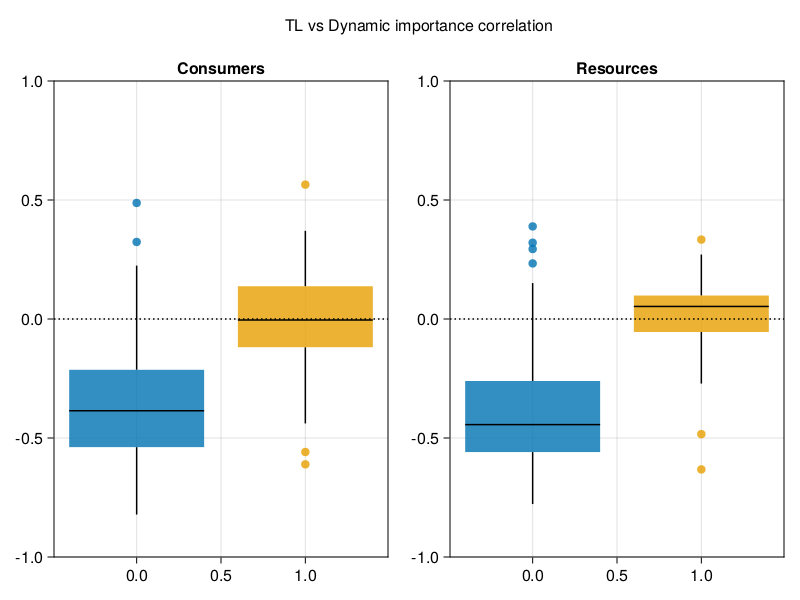

In [94]:
f = Figure()

#plot stability
ax = Axis(f[1,1], title = "Consumers")
boxplot!(ax, zeros(Ncom), res_con[:,1,1])
boxplot!(ax, ones(Ncom), res_con[:,2,1])
hlines!(ax,[0.0], linestyle = :dot, color = :black)
ylims!(ax,-1,1)



ax = Axis(f[1,2], title = "Resources")
boxplot!(ax, zeros(Ncom), res_res[:,1,1])
boxplot!(ax, ones(Ncom), res_res[:,2,1])
hlines!(ax,[0.0], linestyle = :dot, color = :black)
ylims!(ax,-1, 1)


Label(f[0,1:2], "TL vs Dynamic importance correlation")



f



In [131]:
L = c.N + c.M
vals = eigvals(J)
v = eigvecs(J)
s = zeros(Complex, L)
for i = 1:L
    for n = eachindex(vals)
        s[i] += abs(v[i,n]) / vals[n]
    end
end

log.(-s)

120-element Vector{ComplexF64}:
 0.3384225163514652 - 0.0im
 0.8617664039052658 - 0.0im
 0.8036232656676903 - 0.0im
 1.5958304500266243 - 0.0im
 1.4078747639754763 - 0.0im
 1.5522120498212242 - 0.0im
 0.6927135281254008 - 0.0im
  1.956939057283736 - 0.0im
  1.620143318013901 - 0.0im
 1.0396144171727533 - 0.0im
 2.8548994288721534 - 0.0im
 2.3227003344175166 - 0.0im
 3.0202858621927557 - 0.0im
                    ⋮
  2.546340619641959 - 0.0im
 2.5685684252963057 - 0.0im
  2.118861824950295 - 0.0im
 1.9737618305717821 - 0.0im
 2.2488881284743294 - 0.0im
 2.0449299180699936 - 0.0im
 2.3250448743564553 - 0.0im
 1.9959380119534929 - 0.0im
 1.9168644132206183 - 0.0im
  2.273718950988064 - 0.0im
 1.8373943477384633 - 0.0im
   2.45887744240757 - 0.0im

## Empirical Data

In [717]:
#read empirical matricies
C = readdlm("../data/C_mat.csv",',') .> 0
K = readdlm("../data/D_mat.csv",',') .> 0;

┌ Warning: Since there are a lot of edges (578 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/yyvus/src/recipes.jl:526


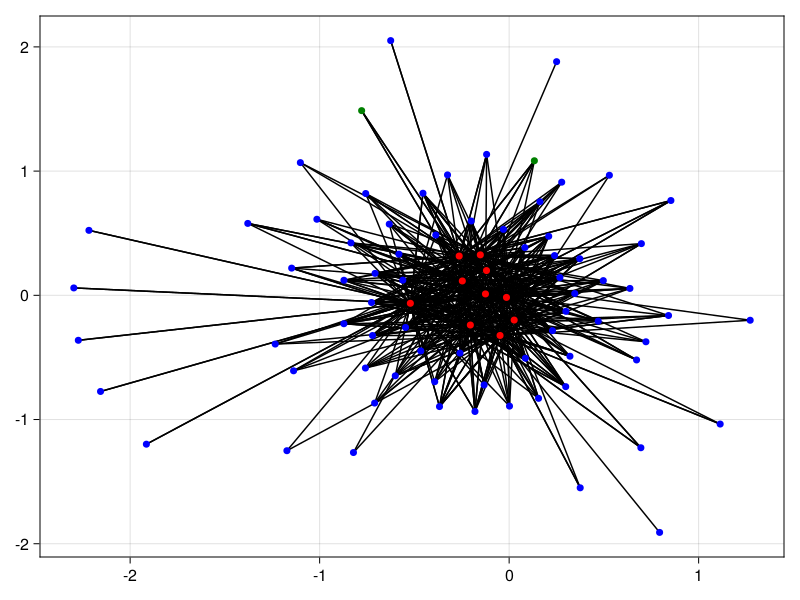

In [781]:
N = size(C)[1]
non_zero = (sum(C, dims = 1)[:] .!= 0) .& (sum(K, dims = 1)[:] .!= 0)

ind = rand(1:N, 10)

U = C[ind,non_zero]
L = K[ind,non_zero]

ind_2 = findall(sum(U, dims = 1)[:] .!= 0)

c = MiCRM_stability.Community(length(ind),length(ind_2), U[:,ind_2], L[:,ind_2])
check_connected(c)


fig = Figure()
ax = Axis(fig[1,1])
plot_com!(c,ax, as = 0.001)
fig